# 연습문제 6번

## ID3 Decision Tree ,  CART Decision Tree

## pruning

### wine data load

In [27]:
import numpy as np
import pandas as pd

feature_names = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                 'Magnesium', 'Total phenols', 'Flavanoids', 
                'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                'Hue', 'OD280', 'Proline']
data = pd.read_csv('./data/wine/wine.txt', sep=',', 
                   names=['label'] + feature_names)

In [28]:
data

,label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [29]:
x = data.drop(['label'], axis=1)
y = data['label']

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

## Decision Tree from scikit-learn

### ID3 Decision Tree ( information gain )

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

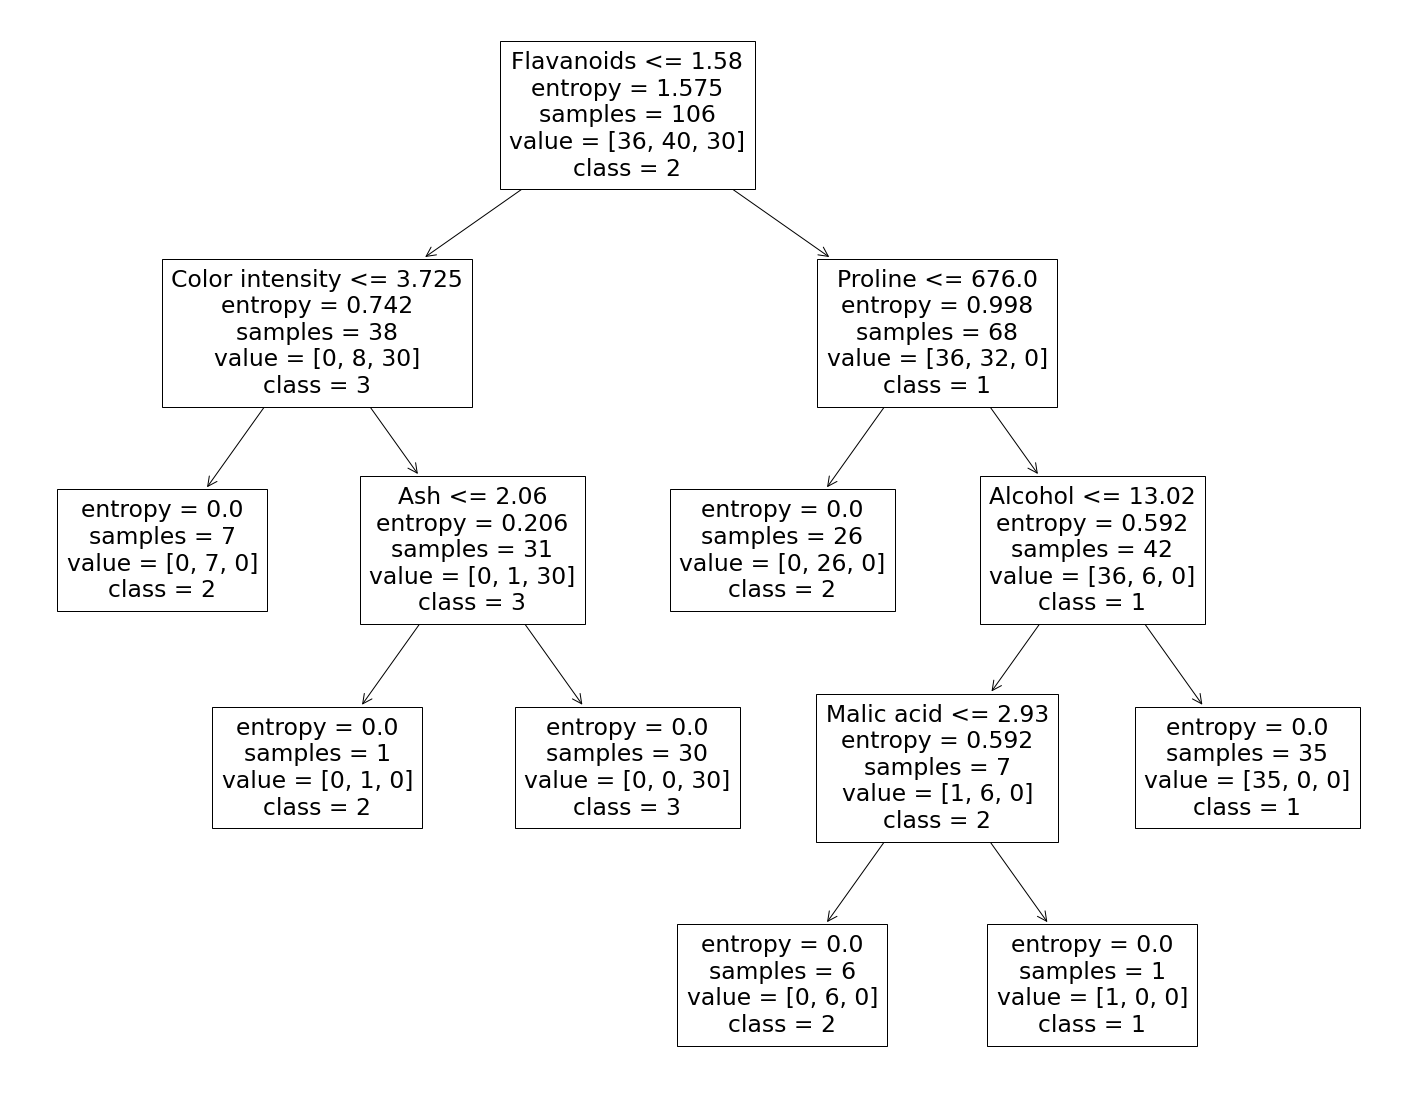

In [32]:
from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(clf, feature_names=feature_names, class_names=['1','2','3'])

In [33]:
clf.score(x_test, y_test)

1.0

### CART Decision Tree ( Gini index )

In [34]:
clf = DecisionTreeClassifier(criterion='gini')

clf.fit(x_train, y_train)

DecisionTreeClassifier()

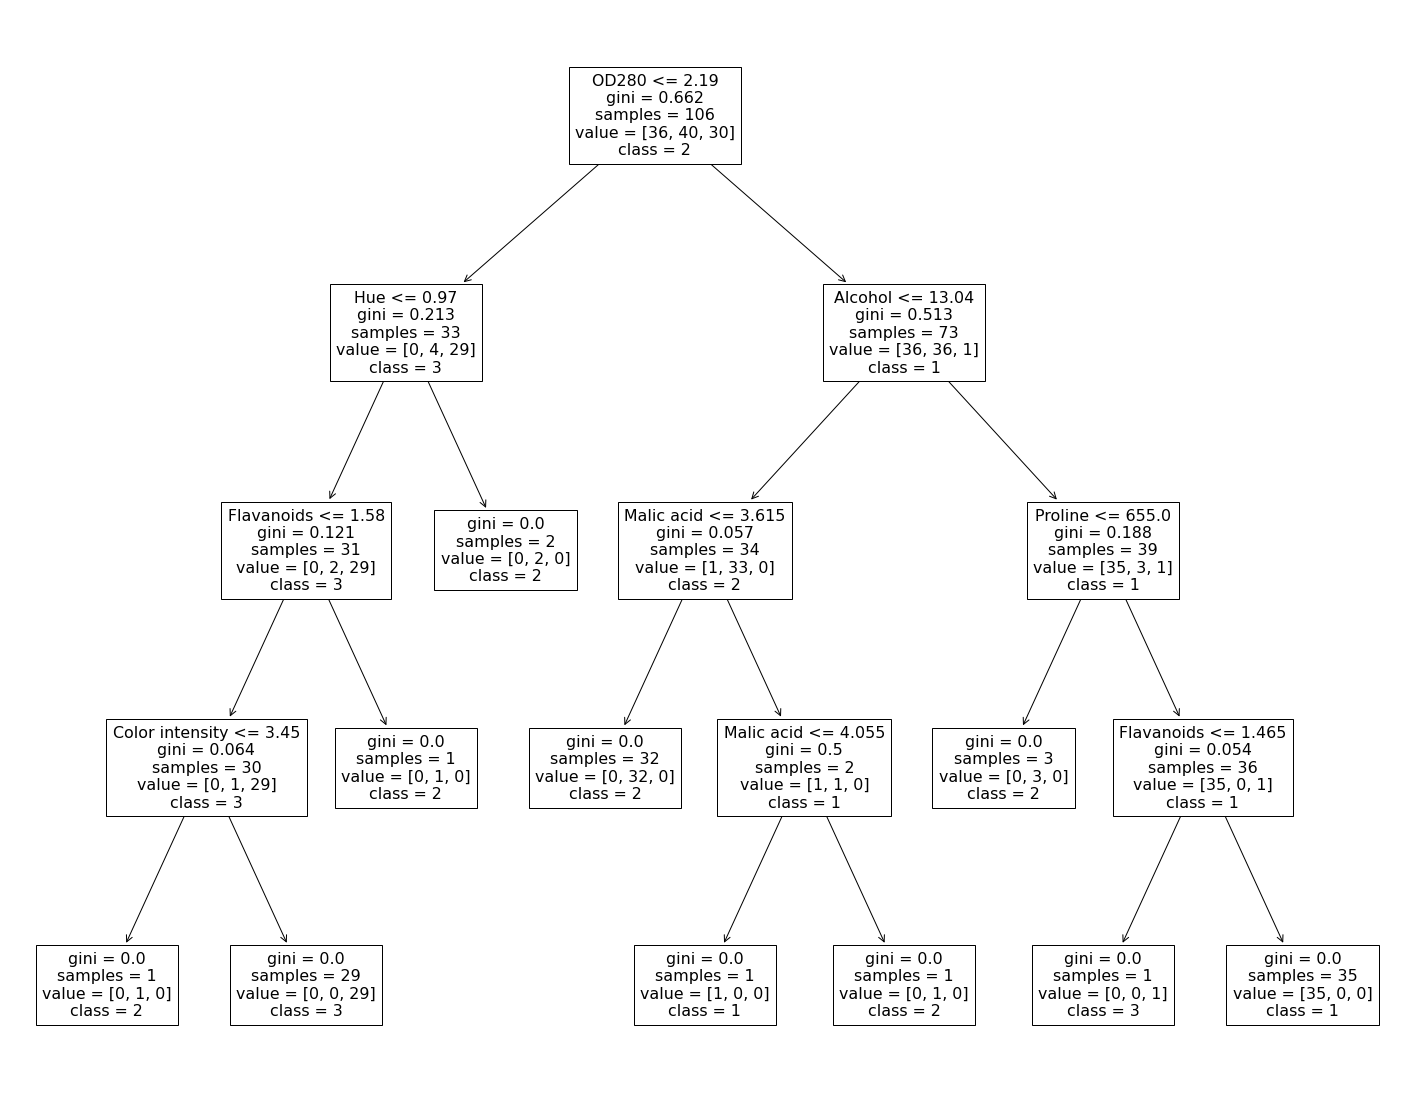

In [35]:
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(clf, feature_names=feature_names, class_names=['1','2','3'])

In [37]:
clf.score(x_test, y_test)

0.9722222222222222

### custom ID3 Decision Tree

In [36]:
import math

class Node:
    def __init__(self, label=None):
        self.feature_name = None
        self.t = None
        self.criterion = None
        
        self.samples = None
        self.label_samples = None
        
        self.feature_val_lst = []
        self.child_node_lst = []
        
        self.label = label

In [132]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

class DecisionTree:
    def __init__(self, criterion='entropy'):
        self.criterion = criterion
    
    def AllEqual(self, D, A):
        for att in A:
            if len(D[att].unique()) > 1:
                return False
        return True
    
    def Entropy(self, D):
        ent = 0
        length = len(D)

        for count in D['label'].value_counts():
            p = count / length
            ent -= p * math.log(p, 2)
        return ent
    
    def Gain(self, D, a):
        a_val_lst = np.sort(D[a].unique())
        gain_lst = []  # (gain, t)
        length = len(D)
        ent_D = self.Entropy(D)
        
        for i in range(len(a_val_lst) - 1):
            t = (a_val_lst[i] + a_val_lst[i+1]) / 2
            gain = ent_D

            for i in range(2):
                D_t = D[(-1)**i * D[a] < (-1)**i * t]
                gain -= self.Entropy(D_t) * len(D_t) / length
            gain_lst += [(gain, t)]

        return max(gain_lst, key=lambda x: x[0])
    
    def Gini(self, D):
        gini = 1
        length = len(D)

        for count in D['label'].value_counts():
            p = count / length
            gini -= p * p
        return gini
    
    def Gini_index(self, D, a):
        a_val_lst = np.sort(D[a].unique())
        gini_index_lst = [] # (gini_index, t)
        length = len(D)
        
        for i in range(len(a_val_lst) - 1):
            t = (a_val_lst[i] + a_val_lst[i+1]) / 2
            gini_index = 0

            for i in range(2):
                D_t = D[(-1)**i * D[a] < (-1)**i * t]
                gini_index += self.Gini(D_t) * len(D_t) / length
            gini_index_lst += [(gini_index, t)]

        return min(gini_index_lst, key=lambda x: x[0])
    
    def BestAtt(self, D, A):   
        if self.criterion == 'entropy':
            gain_lst = [] # (gain, attribute, t)

            for att in A:
                gain, t = self.Gain(D, att)
                gain_lst += [(gain, att, t)]

            return max(gain_lst, key=lambda x: x[0])
        
        elif self.criterion == 'gini':
            gini_index_lst = [] # (gini, attribute, t)
    
            for att in A:
                gini_index, t = self.Gini_index(D, att)
                gini_index_lst += [(gini_index, att, t)]

            return min(gini_index_lst, key=lambda x: x[0])
    
    def TreeGenerate(self, D, A):  # D: data, A: 속성  A_type: set 
        node = Node()
        node.criterion = self.Entropy(D) if self.criterion == 'entropy' else self.Gini(D)
        node.samples = len(D)
        node.label_samples = list(D['label'].value_counts().sort_index().values)
        node.label = D['label'].value_counts().idxmax()

        if len(D['label'].unique()) == 1 or self.AllEqual(D, A):
            return node

        _, best_att, t = self.BestAtt(D, A)
        node.feature_name = best_att
        node.t = t

        for i in range(2):
            D_v = D[(-1)**i * D[best_att] < (-1)**i * t]

            node.feature_val_lst += [i]
            node.child_node_lst += [self.TreeGenerate(D_v, A)]
        
        return node
    
    def fit(self, x, y):
        train = pd.concat([x, y], axis=1)
        self.root = self.TreeGenerate(train, set(x.columns))
    
    def predict_tree(self, x, node):
        label = node.label
        for i in range(len(node.feature_val_lst)):
            if (-1)**i * x[node.feature_name].values[0] <= (-1)**i * node.t:
                label = self.predict_tree(x, node.child_node_lst[i])
                break
        return label
    
    def predict(self, x):
        return self.predict_tree(x, self.root)
    
    def accuracy(self, x, y):
        pred_lst = []
        for i in range(len(x)):
            pred = self.predict(x.iloc[i:i+1])
            pred_lst += [pred]
        
        return np.mean(np.array(pred_lst) == y)
    
    def _node_label(self, node):
        label = "{} = {}\n{} = {}\n{} = {}\n{} = {}\n{} = {}".format(node.feature_name, node.t, 
                                                                     self.criterion, node.criterion, 
                                                                    "samples", node.samples, 
                                                                    "value", str(node.label_samples),
                                                                    "class", node.label)
        return label
    
    def _add_node(self, node, parent_node_label, g):
        node_label = self._node_label(node)
        g.add_node(node_label)
        g.add_edge(parent_node_label, node_label)
        
        for child_node in node.child_node_lst:
            self._add_node(child_node, node_label, g)
    
    def visualize(self, figsize=(15, 10), node_size=10000):
        g = nx.DiGraph()
        node = self.root
        node_label = self._node_label(node)
        
        g.add_node(node_label)
        
        for child_node in node.child_node_lst:
            self._add_node(child_node, node_label, g)
        
        pos = graphviz_layout(g, prog='dot')
        plt.figure(figsize=figsize)
        nx.draw(g, pos=pos, with_labels=True, node_shape='s', node_color='white', 
               node_size=node_size)
        plt.show()
        

In [143]:
decision_tree = DecisionTree(criterion='entropy')

In [144]:
decision_tree.fit(x_train, y_train)

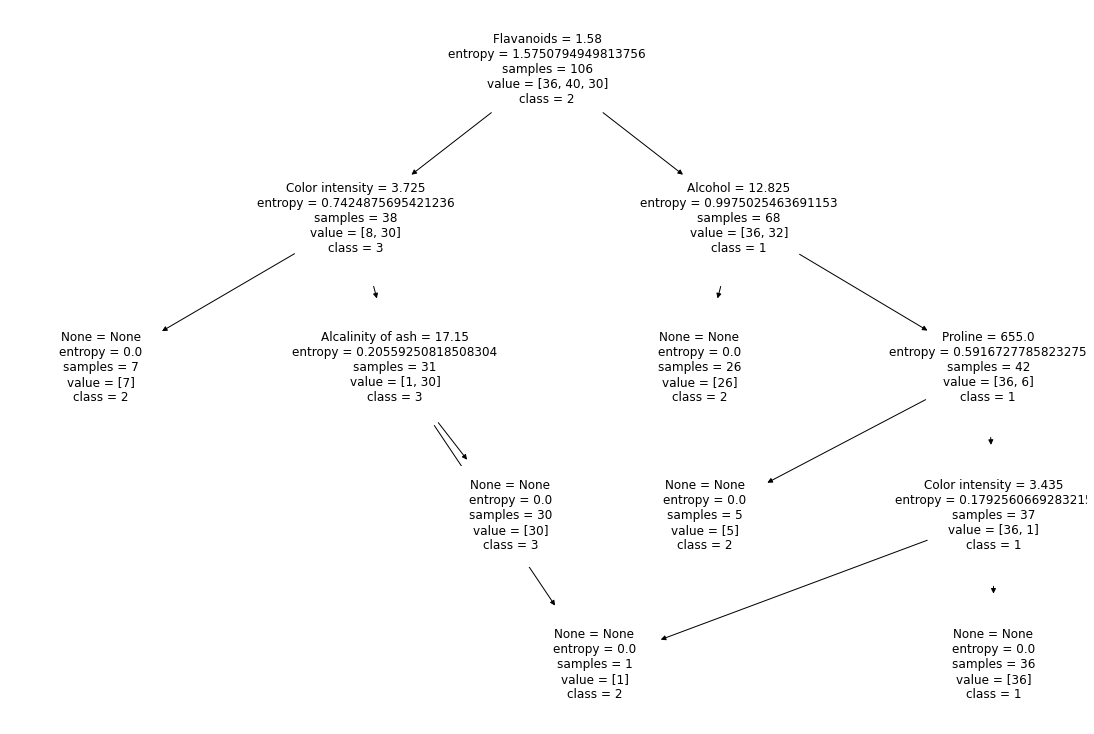

In [136]:
decision_tree.visualize()

In [145]:
decision_tree.accuracy(x_test, y_test)

1.0

### custom CART Decision Tree

In [139]:
decision_tree = DecisionTree(criterion='gini')

In [140]:
decision_tree.fit(x_train, y_train)

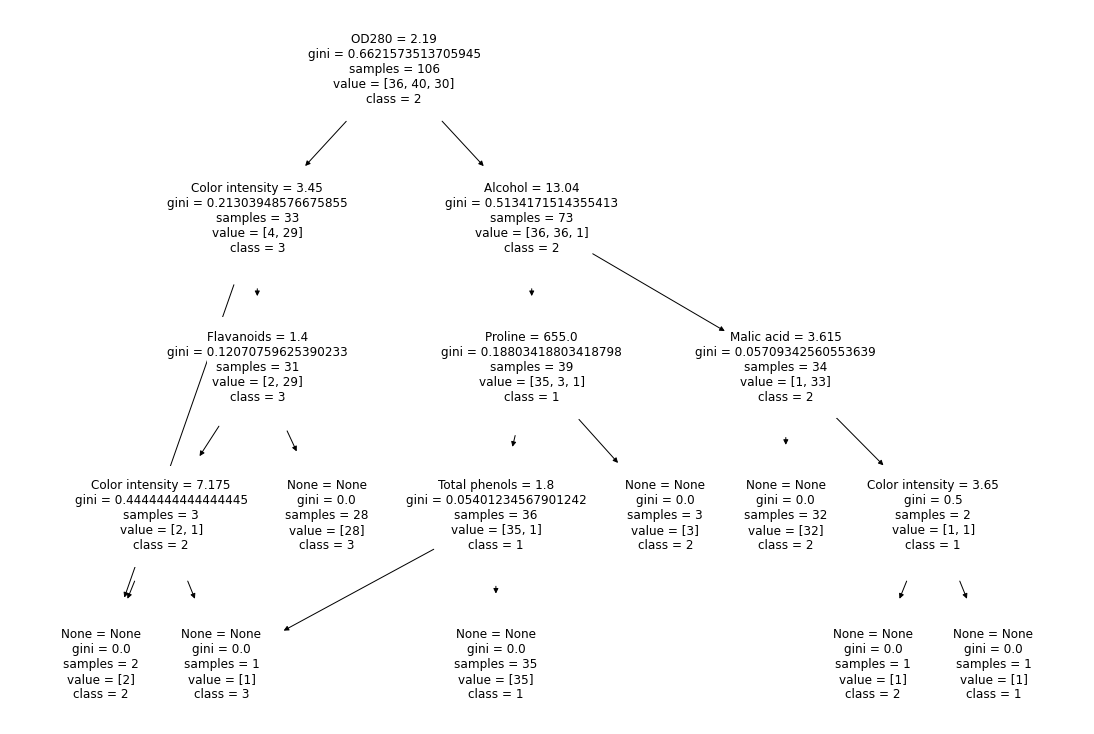

In [141]:
decision_tree.visualize()

In [142]:
decision_tree.accuracy(x_test, y_test)

0.9722222222222222

### pruning Decision Tree

In [147]:
import math

class Node:
    def __init__(self, label=None):
        self.parent_node = None
        
        self.feature_name = None
        self.t = None
        self.criterion = None
        
        self.samples = None
        self.label_samples = None
        
        self.feature_val_lst = []
        self.child_node_lst = []
        
        self.label = label

In [185]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

class DecisionTree:
    def __init__(self, criterion='entropy', pruning=None):
        self.criterion = criterion
        self.pruning = pruning
    
    def AllEqual(self, D, A):
        for att in A:
            if len(D[att].unique()) > 1:
                return False
        return True
    
    def Entropy(self, D):
        ent = 0
        length = len(D)

        for count in D['label'].value_counts():
            p = count / length
            ent -= p * math.log(p, 2)
        return ent
    
    def Gain(self, D, a):
        a_val_lst = np.sort(D[a].unique())
        gain_lst = []  # (gain, t)
        length = len(D)
        ent_D = self.Entropy(D)
        
        for i in range(len(a_val_lst) - 1):
            t = (a_val_lst[i] + a_val_lst[i+1]) / 2
            gain = ent_D

            for i in range(2):
                D_t = D[(-1)**i * D[a] < (-1)**i * t]
                gain -= self.Entropy(D_t) * len(D_t) / length
            gain_lst += [(gain, t)]

        return max(gain_lst, key=lambda x: x[0])
    
    def Gini(self, D):
        gini = 1
        length = len(D)

        for count in D['label'].value_counts():
            p = count / length
            gini -= p * p
        return gini
    
    def Gini_index(self, D, a):
        a_val_lst = np.sort(D[a].unique())
        gini_index_lst = [] # (gini_index, t)
        length = len(D)
        
        for i in range(len(a_val_lst) - 1):
            t = (a_val_lst[i] + a_val_lst[i+1]) / 2
            gini_index = 0

            for i in range(2):
                D_t = D[(-1)**i * D[a] < (-1)**i * t]
                gini_index += self.Gini(D_t) * len(D_t) / length
            gini_index_lst += [(gini_index, t)]

        return min(gini_index_lst, key=lambda x: x[0])
    
    def BestAtt(self, D, A):   
        if self.criterion == 'entropy':
            gain_lst = [] # (gain, attribute, t)

            for att in A:
                gain, t = self.Gain(D, att)
                gain_lst += [(gain, att, t)]

            return max(gain_lst, key=lambda x: x[0])
        
        elif self.criterion == 'gini':
            gini_index_lst = [] # (gini, attribute, t)
    
            for att in A:
                gini_index, t = self.Gini_index(D, att)
                gini_index_lst += [(gini_index, att, t)]

            return min(gini_index_lst, key=lambda x: x[0])
    
    def correct_count(self, D):
        if D.empty:
            return 0
        return D['label'].value_counts().max()
    
    def TreeGenerate(self, D, A, D_val=None, parent_node=None):  # D: data, A: 속성  A_type: set 
        node = Node()
        node.criterion = self.Entropy(D) if self.criterion == 'entropy' else self.Gini(D)
        node.samples = len(D)
        node.label_samples = list(D['label'].value_counts().sort_index().values)
        node.label = D['label'].value_counts().idxmax()
        
        node.parent_node = parent_node

        if len(D['label'].unique()) == 1 or self.AllEqual(D, A):
            return node

        _, best_att, t = self.BestAtt(D, A)
        node.feature_name = best_att
        node.t = t
        
        if self.pruning == 'pre':
            D_v_lst = []
            D_v_val_lst = []

            for i in range(2):
                D_v = D[(-1)**i * D[best_att] < (-1)**i * t]
                D_v_lst += [D_v]

                D_v_val = D_val[(-1)**i * D_val[best_att] < (-1)**i * t]
                D_v_val_lst += [D_v_val]

                node.feature_val_lst += [i]

            child_correct_sum = sum(list(map(self.correct_count, D_v_val_lst)))

            if self.correct_count(D_val) < child_correct_sum:
                for i in range(len(D_v_lst)):
                    node.child_node_lst += [self.TreeGenerate(D_v_lst[i], A, 
                                                        D_v_val_lst[i], parent_node=node)]
            else:
                node.feature_val_lst = []

            return node
        else:
            for i in range(2):
                D_v = D[(-1)**i * D[best_att] < (-1)**i * t]

                node.feature_val_lst += [i]
                node.child_node_lst += [self.TreeGenerate(D_v, A)]

            return node
    
    def correct_count_val(self, node, val):
        if val.empty:
            return 0
        return sum(val['label'] == node.label)
    
    def post_pruning(self, node, val):
        cur_node_correct_count = self.correct_count_val(node, val)
        total_correct_count = 0
        
        for i in range(len(node.child_node_lst)):
            j = node.feature_val_lst[i]
            val_val = val[(-1) ** j * val[node.feature_name] < (-1) ** j * node.t]
            _, correct_count = self.post_pruning(node.child_node_lst[i], val_val)
            
            total_correct_count += correct_count
        
        if cur_node_correct_count > total_correct_count:
            node.child_node_lst = []
            node.feature_val_lst = []
            max_correct_count = cur_node_correct_count
        else:
            max_correct_count = total_correct_count
            
        return node, max_correct_count
            
    def fit(self, x, y, x_val=None, y_val=None):
        train = pd.concat([x, y], axis=1)
        if self.pruning=='pre':
            val = pd.concat([x_val, y_val], axis=1)
            self.root = self.TreeGenerate(train, set(x.columns), val)
        else:
            self.root = self.TreeGenerate(train, set(x.columns))
            if self.pruning == 'post':
                val = pd.concat([x_val, y_val], axis=1)
                self.root, _ = self.post_pruning(self.root, val)
    
    def predict_tree(self, x, node):
        label = node.label
        for i in range(len(node.feature_val_lst)):
            if (-1)**i * x[node.feature_name].values[0] <= (-1)**i * node.t:
                label = self.predict_tree(x, node.child_node_lst[i])
                break
        return label
    
    def predict(self, x):
        return self.predict_tree(x, self.root)
    
    def accuracy(self, x, y):
        pred_lst = []
        for i in range(len(x)):
            pred = self.predict(x.iloc[i:i+1])
            pred_lst += [pred]
        
        return np.mean(np.array(pred_lst) == y)
    
    def _node_label(self, node):
        label = "{} = {}\n{} = {}\n{} = {}\n{} = {}\n{} = {}".format(node.feature_name, node.t, 
                                                                     self.criterion, node.criterion, 
                                                                    "samples", node.samples, 
                                                                    "value", str(node.label_samples),
                                                                    "class", node.label)
        return label
    
    def _add_node(self, node, parent_node_label, g):
        node_label = self._node_label(node)
        g.add_node(node_label)
        g.add_edge(parent_node_label, node_label)
        
        for child_node in node.child_node_lst:
            self._add_node(child_node, node_label, g)
    
    def visualize(self, figsize=(15, 10), node_size=10000):
        g = nx.DiGraph()
        node = self.root
        node_label = self._node_label(node)
        
        g.add_node(node_label)
        
        for child_node in node.child_node_lst:
            self._add_node(child_node, node_label, g)
        
        pos = graphviz_layout(g, prog='dot')
        plt.figure(figsize=figsize)
        nx.draw(g, pos=pos, with_labels=True, node_shape='s', node_color='white', 
               node_size=node_size)
        plt.show()
        

### None pruning

In [160]:
decision_tree = DecisionTree(criterion='gini')
decision_tree.fit(x_train, y_train)

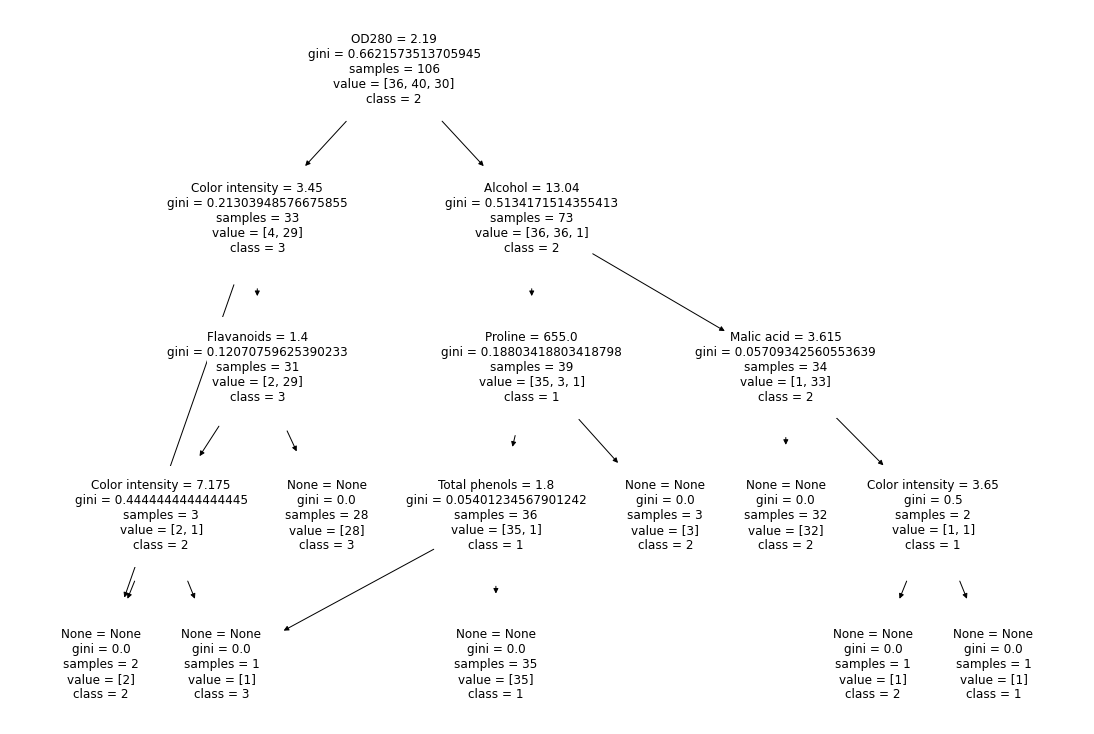

In [161]:
decision_tree.visualize()

### pre-pruning

In [166]:
decision_tree = DecisionTree(criterion='gini', pruning='pre')
decision_tree.fit(x_train, y_train, x_val, y_val)

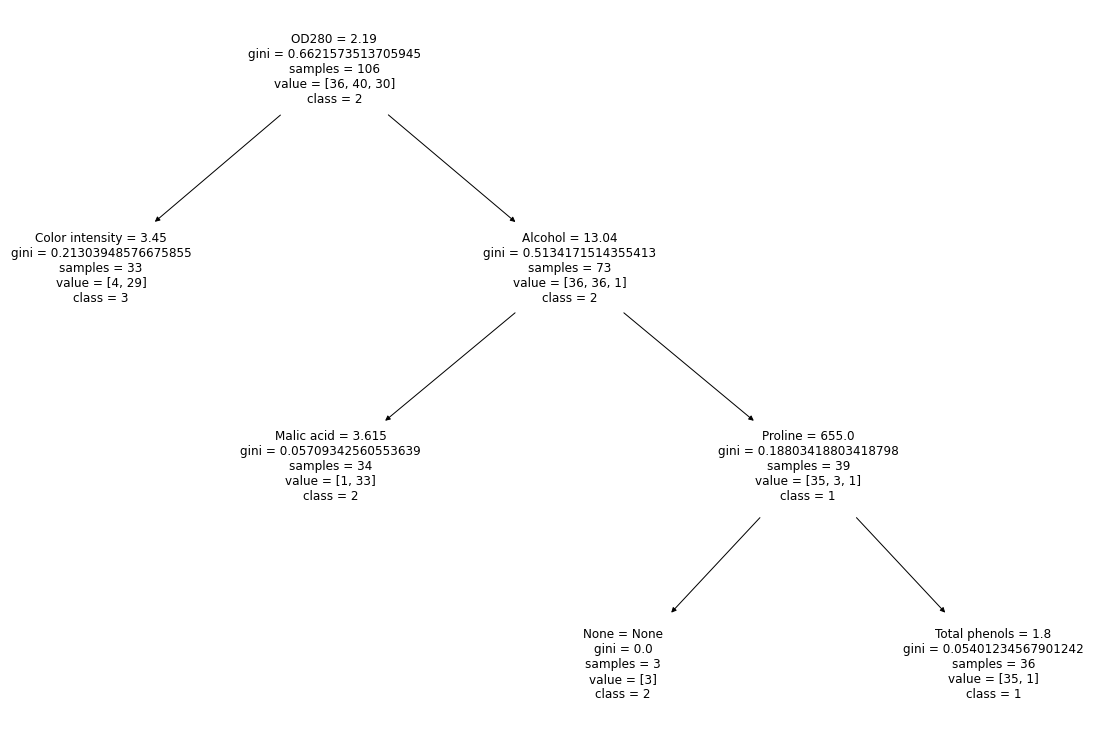

In [167]:
decision_tree.visualize()

In [168]:
decision_tree.accuracy(x_test, y_test)

0.8333333333333334

### post-pruning

In [186]:
decision_tree = DecisionTree(criterion='gini', pruning='post')
decision_tree.fit(x_train, y_train, x_val, y_val)

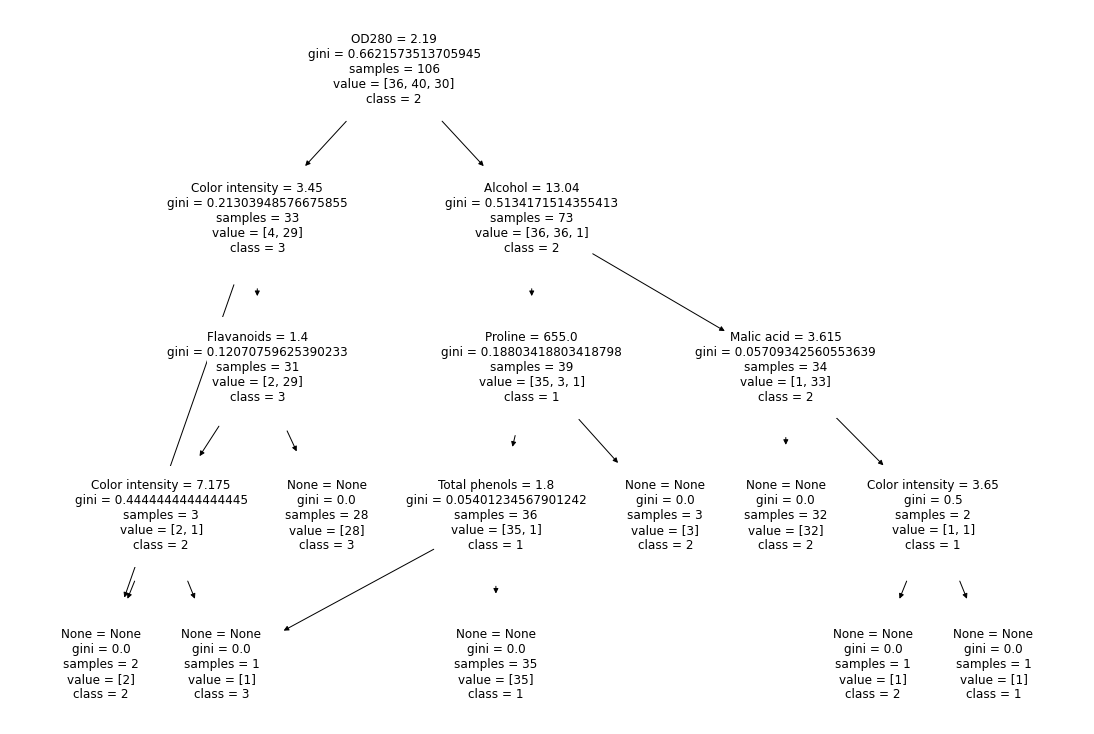

In [175]:
decision_tree.visualize()

In [174]:
decision_tree.accuracy(x_test, y_test)

0.9722222222222222